In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/ann/220206_annkw.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-02-06 01:00:00,#annkw
1,2022-02-06 01:00:00,#annkw
2,2022-02-06 01:00:00,#annkw
3,2022-02-06 01:00:00,#annkw
4,2022-02-06 01:00:00,#annkw
...,...,...
31848,2022-02-06 03:04:52,#annkw 2人とも娘さんだからいつか日向坂入れてくれないかな笑笑
31849,2022-02-06 03:04:52,2週間ぶりの2人のトーク、最高すぎた。 改めて土曜の夜がこんなにも大切だったんだって認識しま...
31850,2022-02-06 03:04:57,良い回でした #annkw
31851,2022-02-06 03:04:57,よく。 春日さんは子供が出来てから 変わった!って話しを いろんな番組でしてたけど 若林さん...


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-02-06 01:00:00,
1,2022-02-06 01:00:00,
2,2022-02-06 01:00:00,
3,2022-02-06 01:00:00,
4,2022-02-06 01:00:00,
...,...,...
31848,2022-02-06 03:04:52,0人とも娘さんだからいつか日向坂入れてくれないかな笑笑
31849,2022-02-06 03:04:52,0週間ぶりの0人のトーク最高すぎた改めて土曜の夜がこんなにも大切だったんだって認識またわ
31850,2022-02-06 03:04:57,良い回でた
31851,2022-02-06 03:04:57,よく春日さんは子供が出来てから変わったって話をいろんな番組でてたけど若林さんは俺も変わるのか...


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-02-06 01:00:00,,0
1,2022-02-06 01:00:00,,0
2,2022-02-06 01:00:00,,0
3,2022-02-06 01:00:00,,0
4,2022-02-06 01:00:00,,0
...,...,...,...
31848,2022-02-06 03:04:52,0人とも娘さんだからいつか日向坂入れてくれないかな笑笑,"[0, 人, 娘, さん, いつか, 日向坂, 入れ, くれ, 笑笑]"
31849,2022-02-06 03:04:52,0週間ぶりの0人のトーク最高すぎた改めて土曜の夜がこんなにも大切だったんだって認識またわ,"[0, 週間, ぶり, 0, 人, トーク, 最高, すぎ, 改めて, 土曜, 夜, こんな..."
31850,2022-02-06 03:04:57,良い回でた,"[良い, 回]"
31851,2022-02-06 03:04:57,よく春日さんは子供が出来てから変わったって話をいろんな番組でてたけど若林さんは俺も変わるのか...,"[よく, 春日, さん, 子供, 出来, 変わっ, 話, 番組, で, て, 若林, さん,..."


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-02-06 01:00:00,"[今週, また, ひとつ, なに, 0, 週間, ぶり, joar, なう, 対戦, よろく..."
1,2022-02-06 01:01:00,"[オードリー, 復活, どこ, なく, さ, みい, 0, 週間, ひと, ひと, なに, ..."
2,2022-02-06 01:02:00,"[オードリーのオールナイトニッポン, ニッポン放送, ー, 若林, さん, 居る, ーノヽー..."
3,2022-02-06 01:03:00,"[確か, 田中さん, キレ, て, www, 春日, さん, 聴い, て, なるべく, フラ..."
4,2022-02-06 01:04:00,"[コンタクトレンズ, 無駄, 田中さん, 帰り, なさい, 今晩, リアタイ, ひと, 始ま..."
...,...,...
120,2022-02-06 03:00:00,"[二人, 元気, そう, 安心, 若林, さん, お子さん, 誕生, 来週, 二人, 願い,..."
121,2022-02-06 03:01:00,"[最高, ミッフィー, ちゃん, アディオス, アディオス, コロナ, 療養, 中, 話, ..."
122,2022-02-06 03:02:00,"[若林, さん, 本当に, バナナ, とこ, かい, w, 赤ちゃん, 抱っこ, とこ, 期..."
123,2022-02-06 03:03:00,"[アンガールズ, 平成ノブシコブシ, 面白かっ, オードリー, 安心感, 格別, トレンド,..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
120    None
121    None
122    None
123    None
124    None
Length: 125, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-02-06 01:00:00,0
1,2022-02-06 01:00:00,0
2,2022-02-06 01:00:00,0
3,2022-02-06 01:00:00,0
4,2022-02-06 01:00:00,0
...,...,...
31848,2022-02-06 03:04:52,"[-0.46367097, -0.31710523, 0.38544422, 0.24996..."
31849,2022-02-06 03:04:52,"[-0.07527574, -0.56751186, -0.19373941, 0.1962..."
31850,2022-02-06 03:04:57,"[-1.4722552, 0.23052588, -2.0743005, 1.0818998..."
31851,2022-02-06 03:04:57,"[-0.2683567, 0.020923054, -0.3078008, -0.21191..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-02-06 01:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, [0.09498763, -0.60090..."
1,2022-02-06 01:01:00,"[[-0.74814194, 0.007735297, -0.5643623, 0.4342..."
2,2022-02-06 01:02:00,"[[-0.0038611405, -0.115876295, 0.16685776, -0...."
3,2022-02-06 01:03:00,"[[-0.7993366, -0.28829375, 0.076482154, -0.922..."
4,2022-02-06 01:04:00,"[[-0.15053745, -0.38693896, -0.40618825, -0.28..."
...,...,...
120,2022-02-06 03:00:00,"[[0.3063245, -0.1503651, -0.26434764, -0.39681..."
121,2022-02-06 03:01:00,"[[-0.2209023, 0.45860216, -2.7286768, 1.050850..."
122,2022-02-06 03:02:00,"[[-0.53598267, 1.1275214, 0.67318064, -0.50054..."
123,2022-02-06 03:03:00,"[[0.30093437, 0.2092205, -0.4709382, -0.316287..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-02-06 01:00:00,0.059531,0.167510,0.356054,0.253606,0.290348
1,2022-02-06 01:01:00,0.096135,0.199885,0.334100,0.234521,0.207195
2,2022-02-06 01:02:00,0.141140,0.257863,0.399521,0.283757,0.198513
3,2022-02-06 01:03:00,0.150558,0.269518,0.405642,0.290095,0.189500
4,2022-02-06 01:04:00,0.164436,0.300613,0.431364,0.305398,0.185261
...,...,...,...,...,...,...
120,2022-02-06 03:00:00,0.217824,0.394561,0.576770,0.403603,0.246385
121,2022-02-06 03:01:00,0.278455,0.422775,0.554433,0.415333,0.210267
122,2022-02-06 03:02:00,0.254346,0.435135,0.570887,0.415086,0.216487
123,2022-02-06 03:03:00,0.228574,0.421461,0.577022,0.404509,0.213472


In [15]:
df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220206_ann/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.059531,0.167510,0.356054,0.253606,0.290348,1395
1,2,0.096135,0.199885,0.334100,0.234521,0.207195,932
2,3,0.141140,0.257863,0.399521,0.283757,0.198513,627
3,4,0.150558,0.269518,0.405642,0.290095,0.189500,369
4,5,0.164436,0.300613,0.431364,0.305398,0.185261,225
...,...,...,...,...,...,...,...
120,121,0.217824,0.394561,0.576770,0.403603,0.246385,249
121,122,0.278455,0.422775,0.554433,0.415333,0.210267,130
122,123,0.254346,0.435135,0.570887,0.415086,0.216487,72
123,124,0.228574,0.421461,0.577022,0.404509,0.213472,51


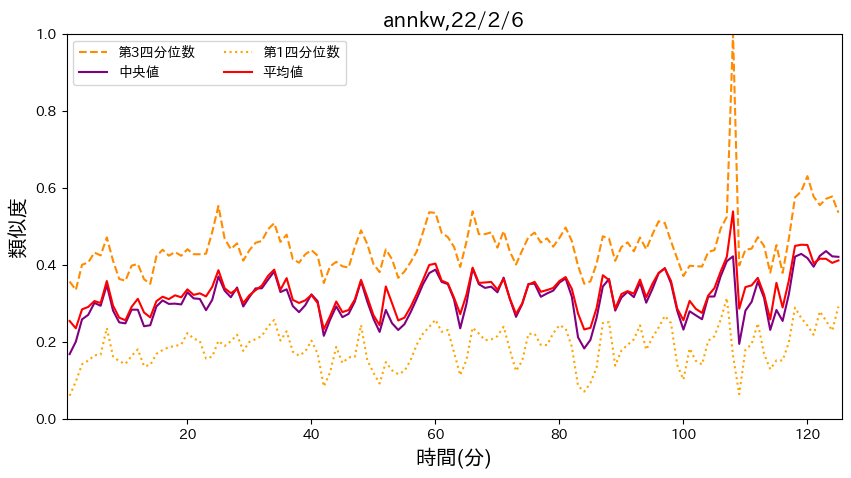

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/2/6", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


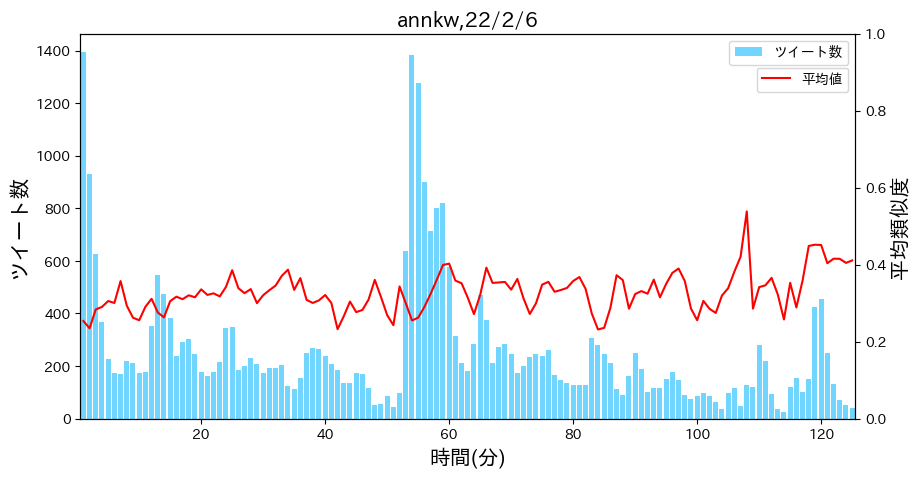

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/2/6", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


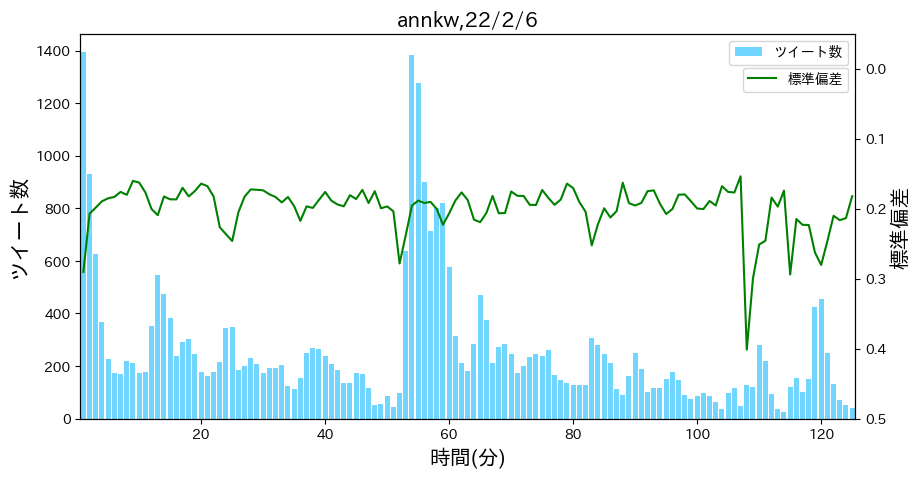

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/2/6", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
